## TensorFlow Ntbk

In [59]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [60]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [61]:
datastore = []
with open("Sarcasm.json", "r") as f:
    lines = f.readlines()
    for items in lines:
        items.replace("'","")              # this is to replace " ' " with ""
        items.replace("/n","")          # this is to replace "/n" with ""
        obj = json.loads(items)
        datastore.append(obj)

In [62]:
print(data[1:3])

[{'is_sarcastic': 0, 'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality', 'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'}, {'is_sarcastic': 0, 'headline': 'eat your veggies: 9 deliciously different recipes', 'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html'}]


In [63]:
sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [64]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [65]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [66]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [67]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [69]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - loss: 0.6430 - accuracy: 0.6475 - val_loss: 0.4964 - val_accuracy: 0.8048 - 4s/epoch - 6ms/step
Epoch 2/30
625/625 - 3s - loss: 0.3923 - accuracy: 0.8431 - val_loss: 0.3620 - val_accuracy: 0.8458 - 3s/epoch - 6ms/step
Epoch 3/30
625/625 - 2s - loss: 0.2995 - accuracy: 0.8803 - val_loss: 0.3362 - val_accuracy: 0.8558 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 3s - loss: 0.2502 - accuracy: 0.9025 - val_loss: 0.3443 - val_accuracy: 0.8467 - 3s/epoch - 4ms/step
Epoch 5/30
625/625 - 1s - loss: 0.2167 - accuracy: 0.9176 - val_loss: 0.3462 - val_accuracy: 0.8467 - 1s/epoch - 2ms/step
Epoch 6/30
625/625 - 3s - loss: 0.1906 - accuracy: 0.9283 - val_loss: 0.3421 - val_accuracy: 0.8547 - 3s/epoch - 5ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1681 - accuracy: 0.9390 - val_loss: 0.3600 - val_accuracy: 0.8489 - 2s/epoch - 2ms/step
Epoch 8/30
625/625 - 1s - loss: 0.1515 - accuracy: 0.9453 - val_loss: 0.3947 - val_accuracy: 0.8379 - 1s/epoch - 2ms/step
Epoch 9/30
625/625 - 1s 

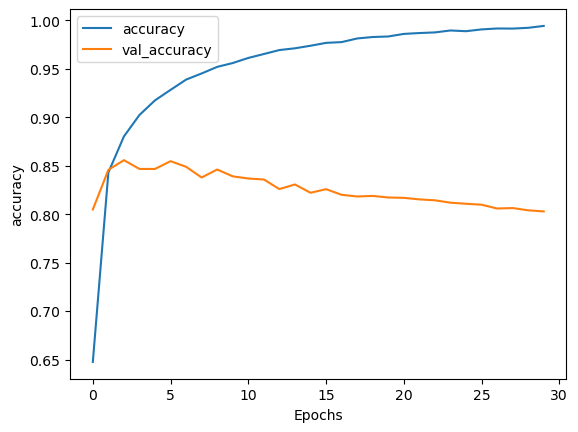

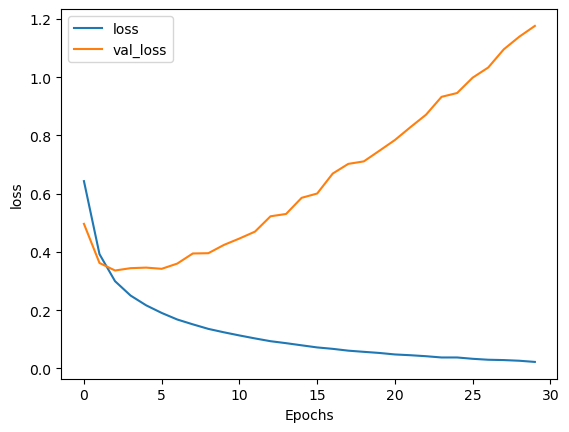

In [73]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [74]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

<OOV> scientists unveil doomsday clock of hair loss ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
eat your veggies: 9 deliciously different recipes
0


In [75]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [77]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [78]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [79]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 1s 573ms/step
[[8.8919771e-01]
 [1.9601154e-09]]
